# Theory

## AutoEncoders

Autoencoders can encode an input image to a latent vector and decode it. But they can't generate novel images.

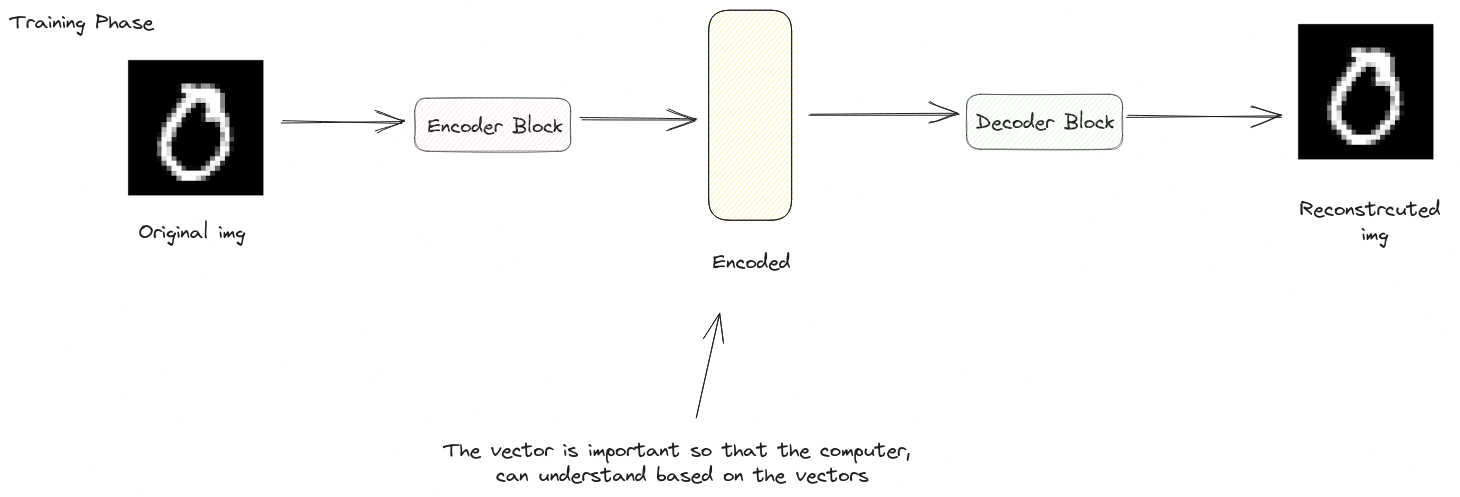

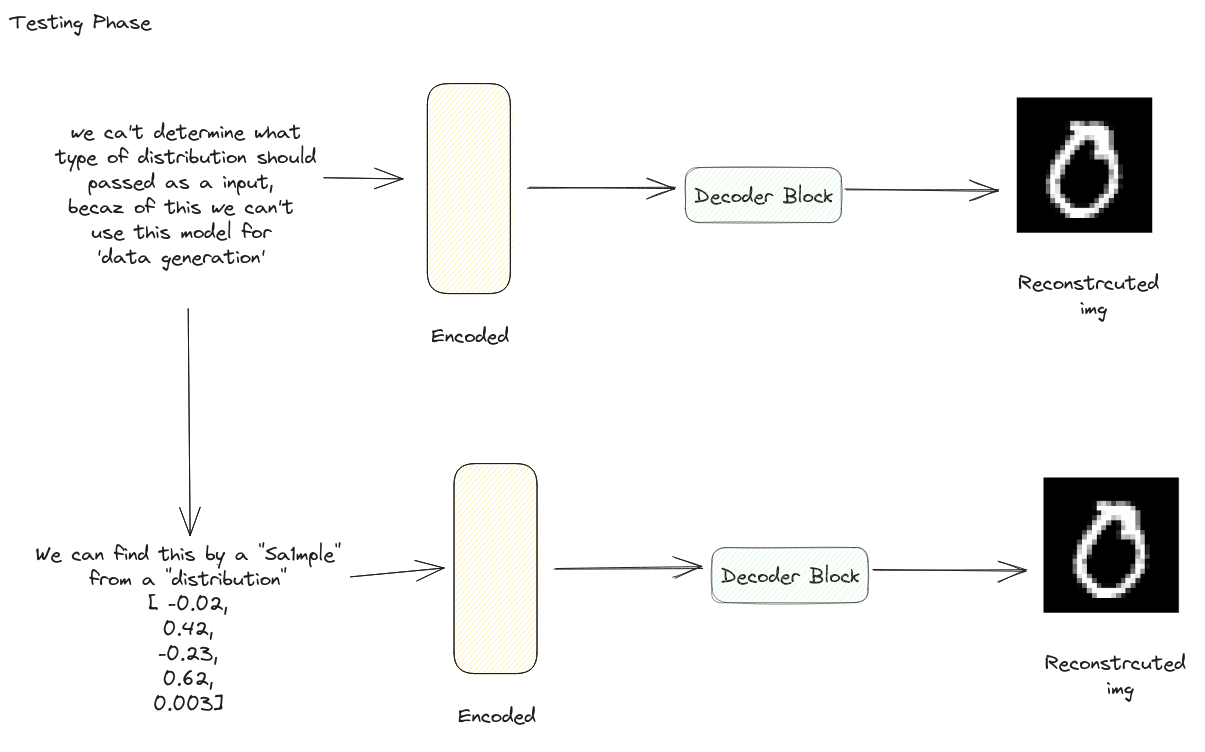

## Variational Autoencoders (VAE)

VAE solves this problem by adding a constraint: the latent vector representation should model a unit gaussian distribution. The Encoder resturn the mean and variance of the learning gaussian.

To generate a new image, we pass a new mean and variance to the decoder. In other words, we 'sample a latent vector' from the gaussian and pass it to the decoder. It improves the network generaization and avoids memorization.

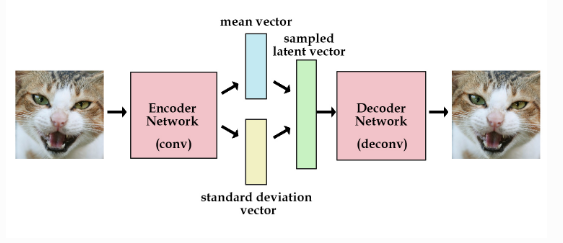

## Loss function

Minimize reconstruction Loss + Regularization loss (latent losss)

The KL (Kullback-Leibler) loss, also known as the KL divergence or relative entropy, is **a measure of how one probability distribution differs from a second, reference distribution**. In the context of variational autoencoders (VAEs), the KL loss is commonly used as a regularization term to encourage the learned latent space to follow a desired prior distribution, often a unit Gaussian.

The formula for KL loss between two distributions P and Q is as follows:

KL(P || Q) = ∑ P(x) log(P(x) / Q(x))

In the case of VAEs, where P represents the posterior distribution (encoder output) and Q represents the prior distribution (usually a unit Gaussian), the formula can be written as:

KL(P || Q) = -0.5 * ∑(1 + log(sigma^2) - mu^2 - sigma^2)

Here, mu represents the mean of the encoder output (latent space representation), and sigma represents the standard deviation. The summation is taken over each element of the latent space representation.

In practice, the KL loss is often combined with the reconstruction loss (such as mean squared error or binary cross-entropy) to form the total loss function for training the VAE. The goal is to minimize the combined loss to simultaneously encourage reconstruction fidelity and regularization of the latent space.

It's worth noting that the KL loss term encourages the learned latent space to resemble the desired prior distribution (e.g., a unit Gaussian), allowing for controlled generation and exploration of the latent space during the VAE training process.

# Code

## Import Modules

In [ ]:
import torch
import torch.nn.functional as F

import torchvision.datasets as datasets

from torch import nn

from tqdm import tqdm
from torch import optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


## Model

In [ ]:
# Input img -> hidden dim -> mean, std -> Parametrization trick -> Decoder -> output img
class VariationalAutoEncoder(nn.Module):
  def __init__(self,input_dim, h_dim=200,z_dim=20):
    super().__init__()

    #encoder
    self.img_2hid = nn.Linear(input_dim,h_dim)
    self.hid_2mu = nn.Linear(h_dim,z_dim)
    self.hid_2sigma = nn.Linear(h_dim, z_dim)

    #decoder
    self.z_2hid = nn.Linear(z_dim,h_dim)
    self.hid_2img = nn.Linear(h_dim,input_dim)

    #activation function
    self.relu = nn.ReLU()

  def encode(self,x):
    #q_phi(z|x) -> that project our data X  into latent variable space
    h = self.relu(self.img_2hid(x))
    mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
    return mu,sigma

  def decode(self,z):
    #p(x|z) -> that generate data given latent variable
    h = self.relu(self.z_2hid(z))
    return torch.sigmoid(self.hid_2img(h))  # the tensor values should be [0,1]


  def forward(self,x):
    mu,sigma = self.encode(x)
    epsilon = torch.randn_like(sigma)
    z_reparameterized = mu + sigma * epsilon
    x_reconstructed = self.decode(z_reparameterized)

    return mu,sigma,x_reconstructed

## Training

In [ ]:
#CONFIGURATION

#STATICE VARAIBLES
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 784
H_DIM = 200
Z_DIM = 20
NUM_EPOCHS = 10
BATCH_SIZE = 32
LR_RATE = 1e-4 # karpathy constant 3e-4


In [ ]:
# DATASET LOADING
dataset = datasets.MNIST(root="./data",train=True, transform = transforms.ToTensor(),download=True)
train_loader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
#MODEL DECALARATION
model = VariationalAutoEncoder(INPUT_DIM,H_DIM,Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
criterion = nn.BCELoss(reduction='sum') #-> 4294.1523 -> 10
# criterion = nn.MSELoss() #-> 0.2201 -> 10

NameError: ignored

In [ ]:
#training loop
output = []
for epoch in range(NUM_EPOCHS):
  loop = tqdm(enumerate(train_loader))
  for i,(x,_) in loop:
    #forward pass
    x = x.to(DEVICE).view(x.size(0),INPUT_DIM)

    mu, sigma, x_recon = model(x)

    #Compute_loss
    reconstruction_loss = criterion(x_recon,x)
    kl_div = -torch.sum(1+ torch.log(sigma.pow(2))-mu.pow(2)-sigma.pow(2))

    #Backprop
    loss = reconstruction_loss + kl_div
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loop.set_postfix(loss=loss.item())

  print(f"Epoch:{epoch+1} Loss:{loss.item():.4f}")
  output.append((epoch,x,x_recon))


1875it [00:22, 81.63it/s, loss=6.97e+3]


Epoch:1 Loss:6973.4038


1875it [00:23, 80.18it/s, loss=5.51e+3]


Epoch:2 Loss:5510.6455


1875it [00:23, 79.77it/s, loss=5.09e+3]


Epoch:3 Loss:5093.6714


1875it [00:23, 80.94it/s, loss=5.2e+3]


Epoch:4 Loss:5197.9756


1875it [00:23, 81.13it/s, loss=5.41e+3]


Epoch:5 Loss:5413.7568


1875it [00:23, 80.58it/s, loss=4.7e+3]


Epoch:6 Loss:4697.7461


1875it [00:23, 81.50it/s, loss=4.64e+3]


Epoch:7 Loss:4637.0254


1875it [00:22, 81.58it/s, loss=4.56e+3]


Epoch:8 Loss:4559.4395


1875it [00:23, 81.48it/s, loss=4.6e+3]


Epoch:9 Loss:4597.1685


1875it [00:23, 79.85it/s, loss=4.29e+3]

Epoch:10 Loss:4294.1523


In [ ]:
#inference code

def inference(digit,num_image=1):
  images = []
  idx=0
  for x,y in dataset:
    if y == idx:
      images.append(x)
      idx+=1
    if idx == 10:
      break


  encoding_digit = []

  for d in range(10):
    with torch.no_grad():
      mu, sigma = model.encode(images[d].view(1,INPUT_DIM))

    encoding_digit.append((mu,sigma))

  mu, sigma = encoding_digit[digit]

  for example in range(num_image):
    epsilon = torch.randn_like(sigma)

    z = mu + sigma*epsilon

    out = model.decode(z)

    out = out.detach().view(-1,1,28,28)

    # save_image(out,f'generated_{digit}_ex{example}.png')
    # print(out[0,0,:,:].shape)
    plt.imshow(out[0,0,:,:])
    plt.show()


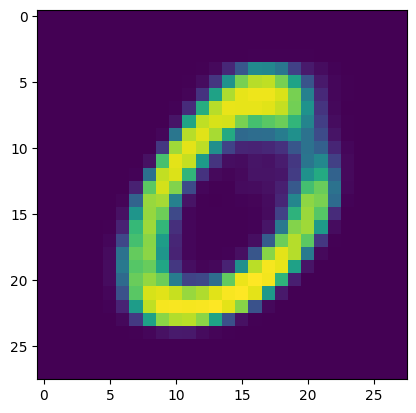

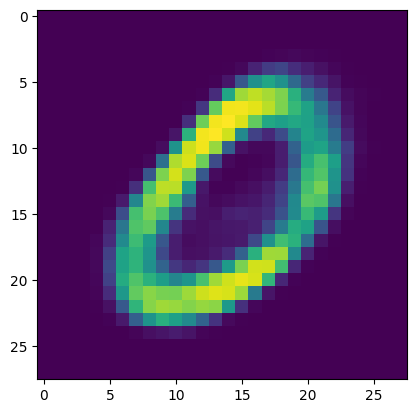

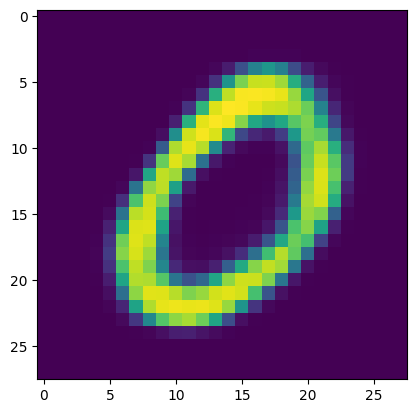

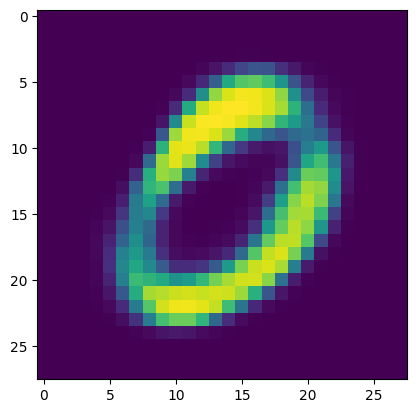

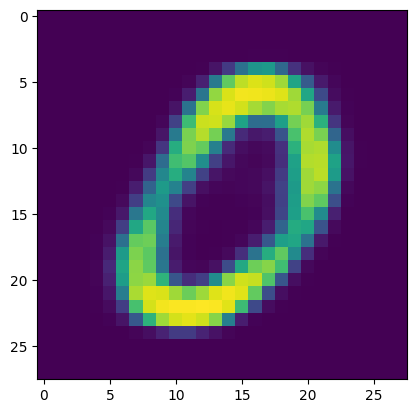

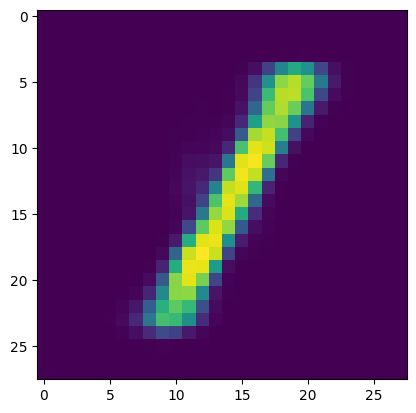

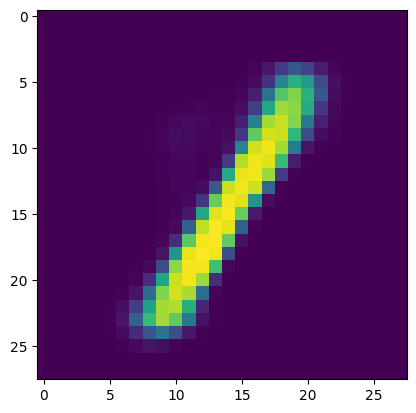

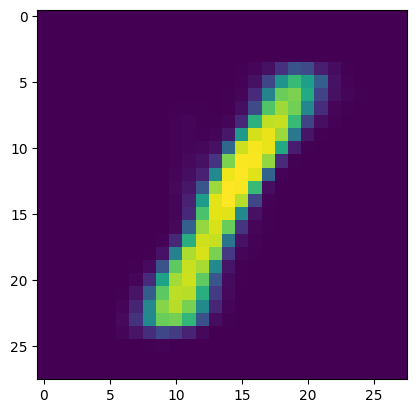

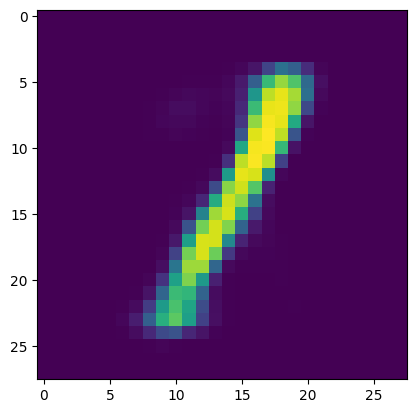

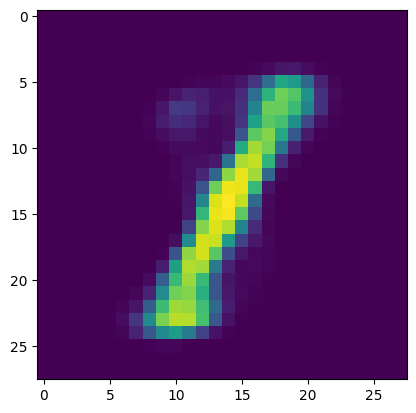

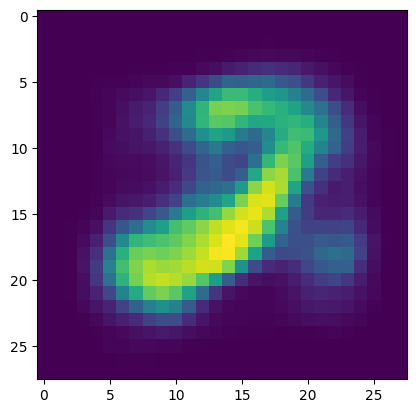

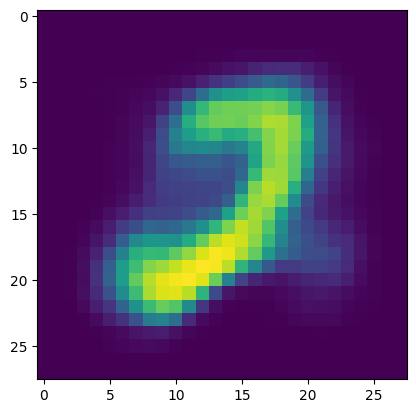

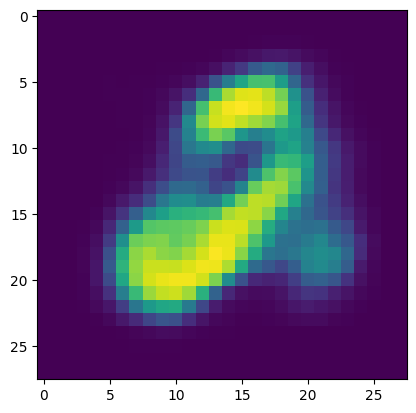

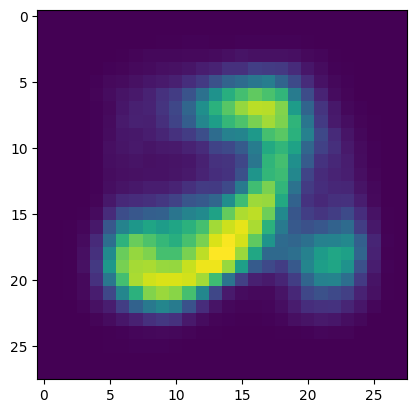

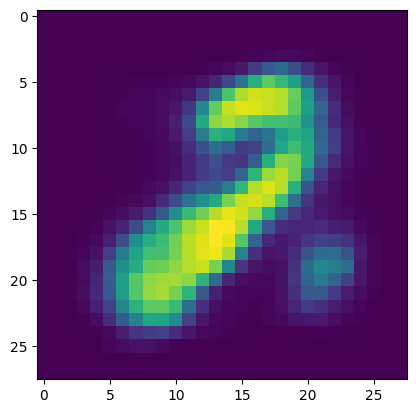

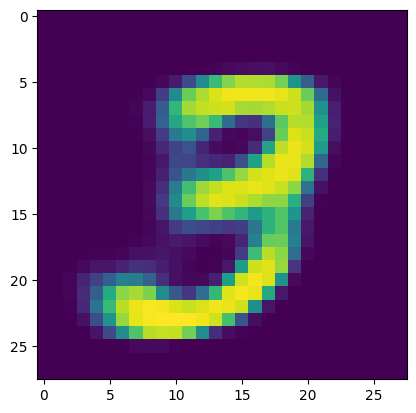

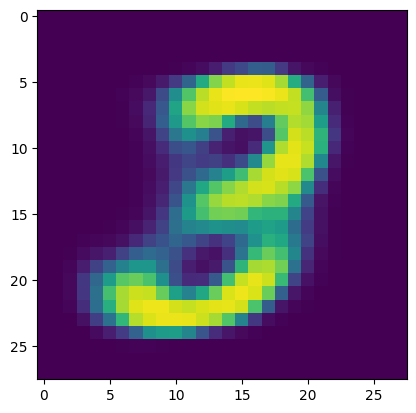

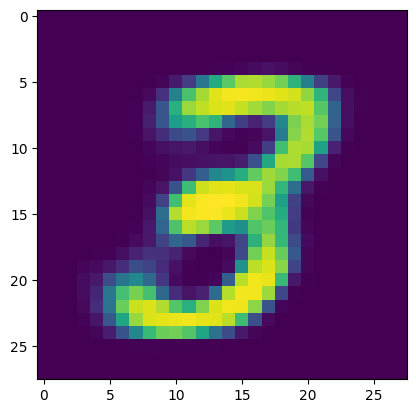

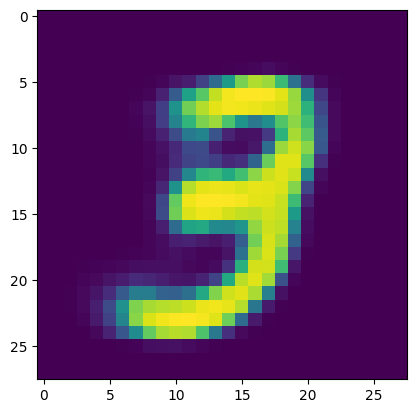

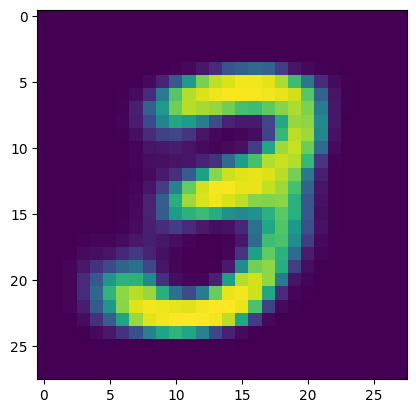

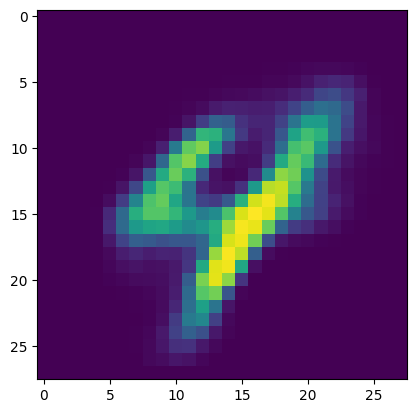

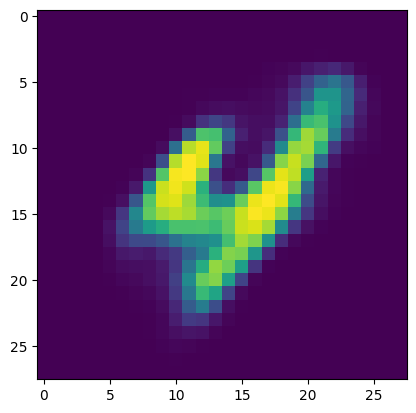

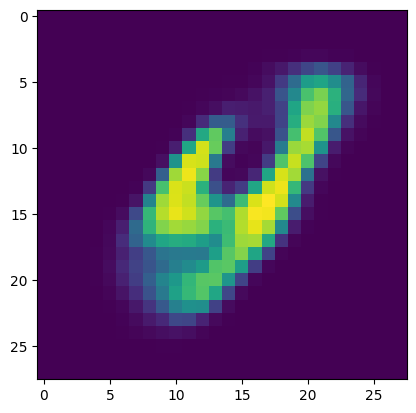

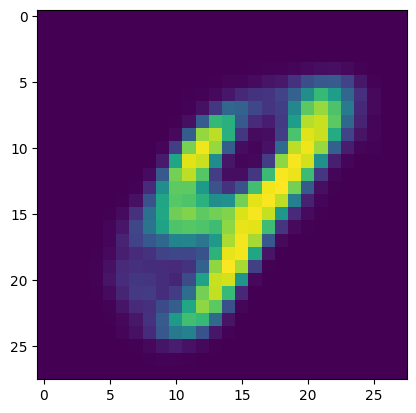

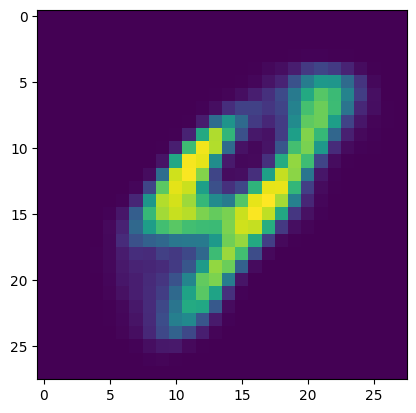

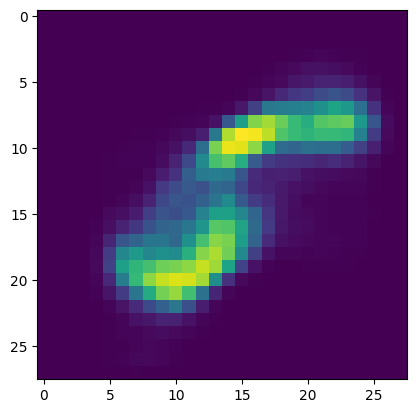

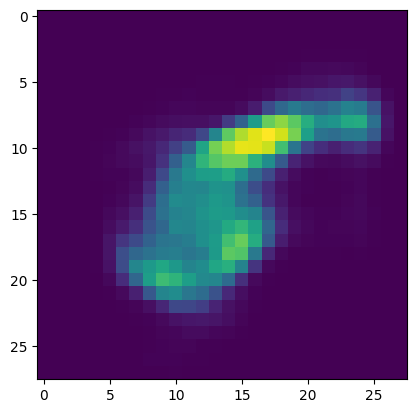

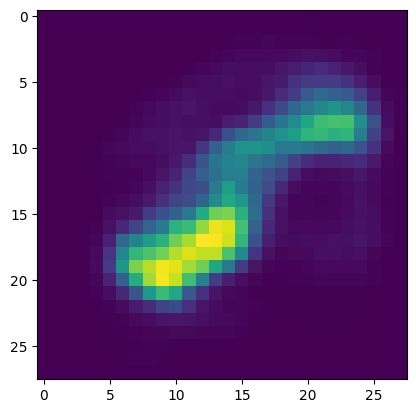

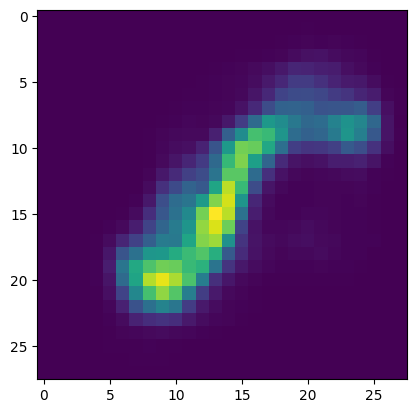

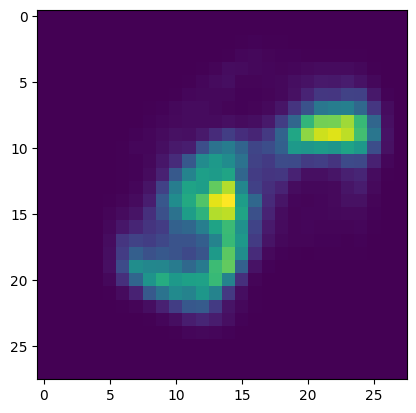

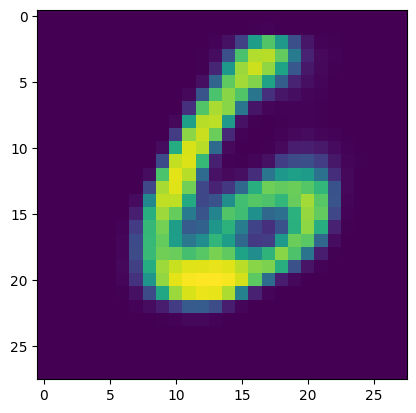

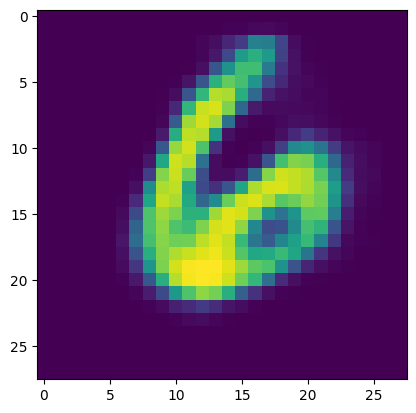

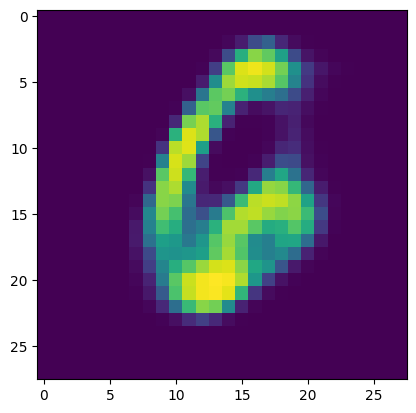

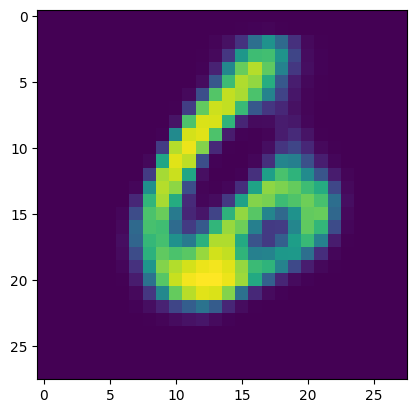

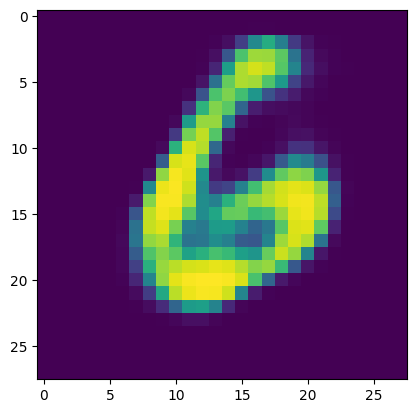

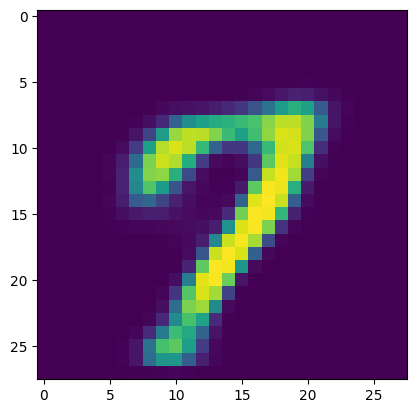

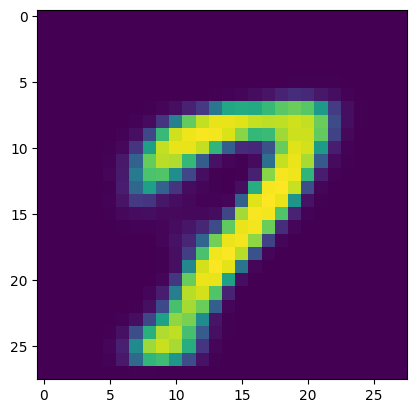

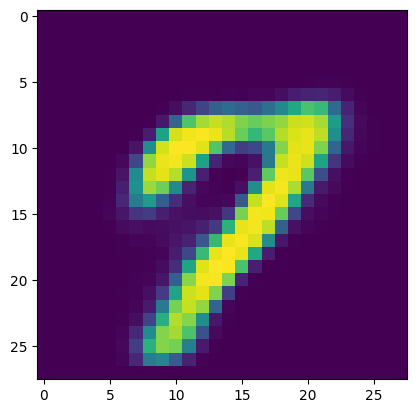

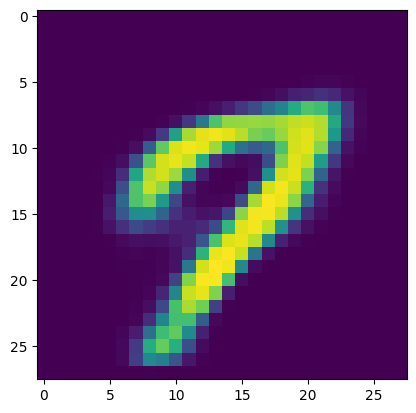

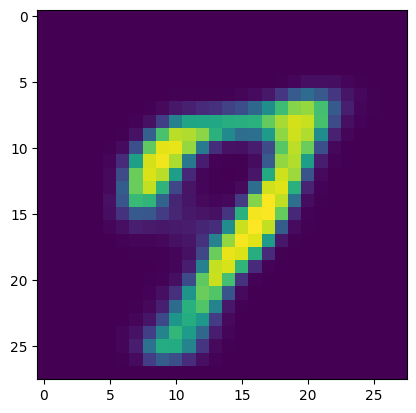

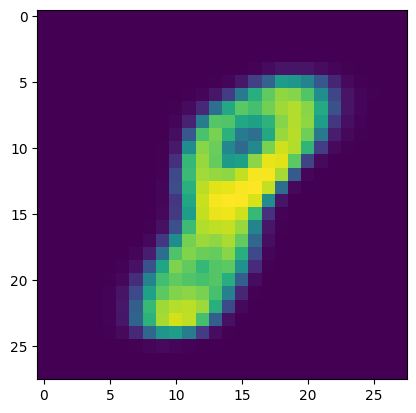

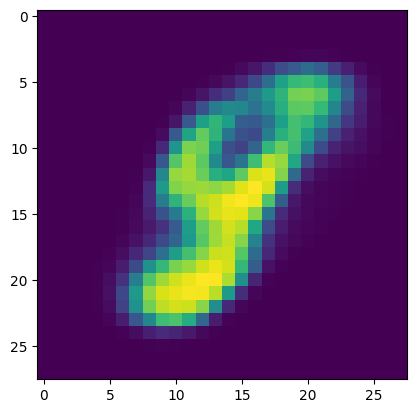

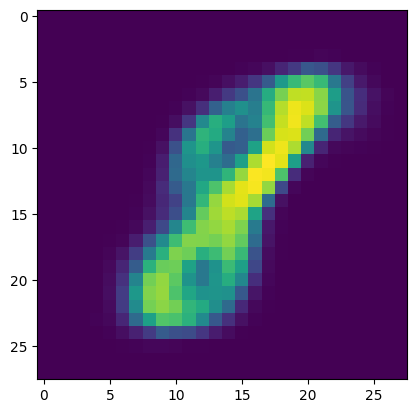

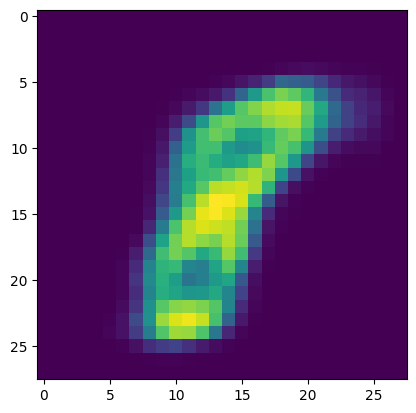

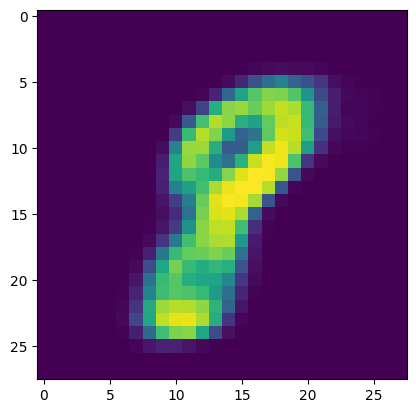

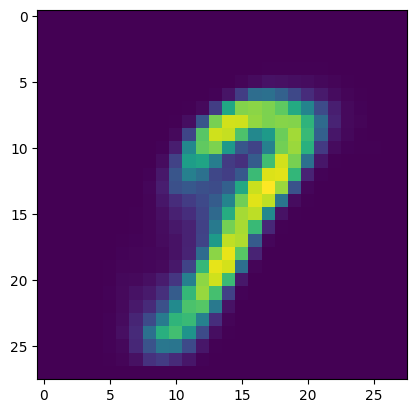

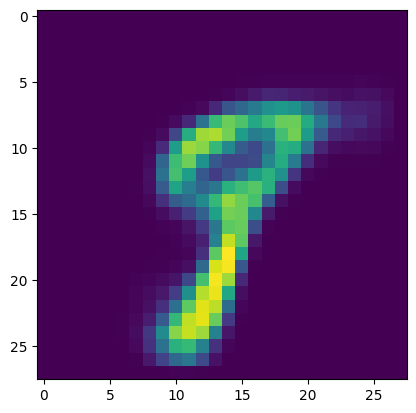

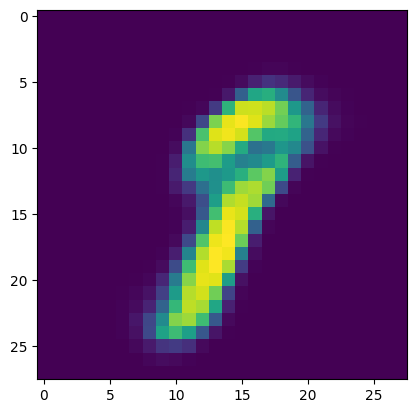

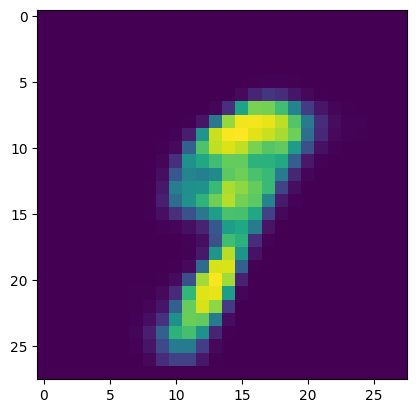

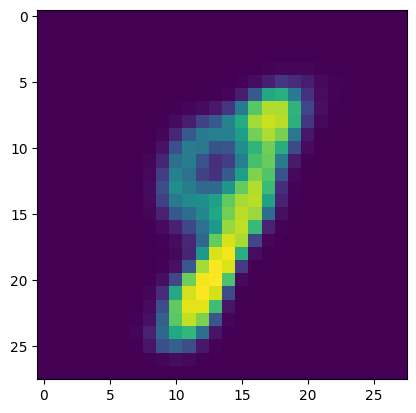

In [ ]:
for idx in range(10):
  inference(idx,num_image=5)

## Convolutional Model

In [ ]:
class VAE_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # N, 1, 28, 28
    self.encoder = nn.Sequential(
        nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1), # N, 16, 14, 14
        nn.ReLU(),
        nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1), # N, 32, 7, 7
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=7), # N, 64, 1, 1
    )
    self.mu = nn.Linear((64*1*1),128)
    self.sigma = nn.Linear((64*1*1),128)

    self.decoder_linear = nn.Linear(128,(64*1*1))
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64,32,kernel_size=7),
        nn.ReLU(),
        nn.ConvTranspose2d(32,16,kernel_size=3,stride=2,padding=1,output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16,1,kernel_size=3,stride=2,padding=1,output_padding=1),
        nn.Sigmoid()
    )


  def encode(self,x):
    x = self.encoder(x)
    x = x.view(x.size(0),-1)
    mu = self.mu(x)
    sigma = self.sigma(x)

    return mu, sigma

  def reparameterized(self,mu,sigma):

    epsilon = torch.randn_like(sigma)
    z_reparameterization = mu + sigma * epsilon

    return z_reparameterization

  def decode(self,z):
    z = self.decoder_linear(z)
    z = z.unsqueeze(2).unsqueeze(2)
    recon = self.decoder(z)
    print(recon.shape)
    return recon

  def forward(self,x):
    mu, sigma = self.encode(x)
    z = self.reparameterized(mu,sigma)
    return mu, sigma, self.decode(z)




In [ ]:
model_cnn = VAE_CNN()
optimizer = optim.Adam(model_cnn.parameters(),lr = 3e-4)
criterion = nn.MSELoss()

In [ ]:
#training loop
num_epochs = 10
outputs = []

for i in range(num_epochs):

  for idx,(img,label) in enumerate(train_loader):

    mu, sigma, recon = model_cnn(img)

    break

  break



torch.Size([32, 128])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])


#### Rough work

In [ ]:
x = torch.randn((4,784))
vae = VariationalAutoEncoder(input_dim=784)
x.shape

torch.Size([4, 784])

In [ ]:
mu,sigma,recon = vae(x)
print(f'mu shape:{mu.shape}\nsigma shape:{sigma.shape}\nrecon shape:{recon.shape}')

mu shape:torch.Size([4, 20])
sigma shape:torch.Size([4, 20])
recon shape:torch.Size([4, 784])


In [ ]:
l = nn.Linear(784,200)

In [ ]:
mat1,mat2 = torch.randn((4, 20)),torch.randn((4, 20))
(mat1 + mat1*mat2).shape

torch.Size([4, 20])

In [ ]:
dataiter = iter(train_loader)

for images,labels in dataiter:
  print(torch.min(images),torch.max(images))
  break

TypeError: ignored

In [ ]:
import math
def calculate_shape(width,kernel_size=2,stride=1,padding=0):
  return math.floor((width+(padding*2)-kernel_size)/stride+1)

In [ ]:
print(calculate_shape(16,7))

10


In [ ]:
in_channels = 32
out_channels = 16
kernel_size = 3
stride = 2
padding = 1

conv = nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,)
conv(torch.randn((1,in_channels,7,7))).shape

torch.Size([1, 16, 13, 13])

In [ ]:
4.43e+3

4430.0